In [6]:
# Change the dataset in global_vars.py to UKB.
from global_vars import *
from commons import *

import glob 
import os

one_time_n4_optimization = True
vol_to_check_list = None #['1942395_20201_2_0'] #['']
exclude = ['1004985_20201_2_0']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def load_ukb_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]

    file_paths = {}
    
    for vol in volumes_to_use:
        if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
            
        opp_paths = glob.glob(f'{data_dir}/{vol}/**opp**_[17s, 17sa,17sb]**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/**in**_[17s,17sa,17sb]**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/**F**_[17s, 17sa,17sb]**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/**W**_[17s, 17sa,17sb]**.nii.gz')
        
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths

file_paths = load_ukb_file_paths()
file_paths

{'1942395_20201_2_0': {'VOLUME_PATHS': {'OPP': ['/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1942395_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17s.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1942395_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sa.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1942395_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz'],
   'IN': ['/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1942395_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1942395_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2a.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1942395_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2b.nii.gz'],
   'F': ['/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1942395_20201_2_0/Dixon_BH_17s_F_Dixon_BH_17s.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UK

In [8]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [9]:
# TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'applying n4 bias field on opp scans of {vol}...')
    vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
    idx = 0
    file_paths[vol]['N4_1'] = []
    for opp_img, bias_field_img, opp_file in vol_parts:
        file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
        idx+=1

In [10]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    print(f'started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'

started with 1942395_20201_2_0...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.    

In [11]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

n4 processing part-2 started with 1942395_20201_2_0...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
-85.0
neagtive value detected
saving directory: temp/UKB/n4_corrected_2/vol/1942395_20201_2_0


In [12]:
# TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'applying n4 bias field on stitched opp scans of {vol}...')
    opp_file = file_paths[vol]['ONE']['OPP']
    n4_counterpart = n4_dict[vol]['N4_2']
    print(opp_file, n4_counterpart['IN_BIAS'])
    opp_img = read_ras(opp_file)
    bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

    file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

applying n4 bias field on stitched opp scans of 1942395_20201_2_0...
temp/UKB/n4_corrected_2/vol/1942395_20201_2_0/OPP_ras_stitched.nii.gz temp/UKB/n4_corrected_2/vol/1942395_20201_2_0/IN_ras_stitched_n4_scaled_bias_field.nii.gz
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
saving directory: temp/UKB/n4_corrected_2/vol/1942395_20201_2_0


In [13]:
def ukb_vol_label_fix(vol, label, use_alternate_approach=False):
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    final_label = np.zeros(tuple(world_shape))
    
    label_affine = label.affinevolume = hist_match(volume)
    vol_affine = vol.affine
    target_affine = vol_affine
    target_header = vol.header

    sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))
    labelmap = label.get_fdata()
    
    if not use_alternate_approach:
        final_label[0:sx+ex, 0:sy+ey, sz:ez] = labelmap
    else:
        final_label[0:sx+ex, 0:sy+ey, sz-20:ez-20] = labelmap

    final_label = np.flip(final_label, axis=0)
    final_label = np.flip(final_label, axis=1)
    
    final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
    
    return vol, final_label_img

def ukb_label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = np.max([img.shape for img, _, _ in label_parts], axis=0)
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape

    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print(lidx, lname)
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        sx,sy,sz,ex,ey,ez = np.abs(get_points(labelmap_img, reference_labelmap))
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
1942395_20201_2_0
['datasets/lablmaps/UKB/1942395_20201_2_0/1942395_opp_Dixon_BH_17sa___ Spleen.nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_opp__Dixon_BH_17sa_ Liver.nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17sa-3.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney (left).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17sa-3.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17sa-3.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_W_Dixon_BH_17sa.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17_comb_01.nii.gz']
Reading Files.....
Reading

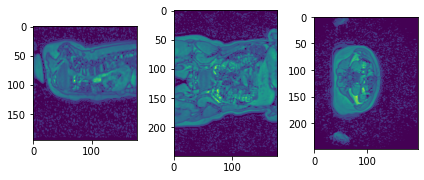

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


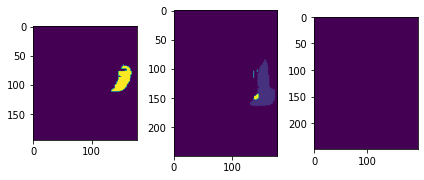

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.


In [14]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    later = None
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
        
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
#     volume = nb.load(file_paths[vol]['ONE']['OPP'])
    img_ras_list = []
    later = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if labelname is None or img_ras is None:
            continue
        img_ras = makeit_3d(img_ras)
        print('After 3d confirmed:', img_ras.shape)
        mode='constant'
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=0, mode=mode, cval=0.0)
        
        if labelname in ['SPLEEN', 'PANCREAS']:
            later.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
        else:
            img_ras_list.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])

    img_ras_list.extend(later)
        
    s_label = ukb_label_parts(img_ras_list)
    s_label = drop_overlapped_pixels(s_label, np.array(img_ras_list)[:, 1])
    
    if vol == '1004985_20201_2_0':
        volume, s_label = ukb_vol_label_fix(volume, s_label, True)
    else:
        volume, s_label = ukb_vol_label_fix(volume, s_label)

    volume = hist_match(volume)
    
    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))
    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    print('FINISHED.')
    